# Model Family Comparisons

**Goal**: Compare architectural parameters across different model families (LLaMA, BERT, GPT, DeepSeek, Mistral, etc.)

**Key Questions**:
1. How do parameter distributions differ between families?
2. Which families use specific techniques (GQA, MoE)?
3. What makes DeepSeek/Mistral architecturally distinctive?

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Style matching main repo
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [18]:
df = pd.read_csv('../data/model_configs_expanded.csv', low_memory=False)

# Convert numeric columns to proper numeric types
numeric_cols = [
    'config_hidden_size', 'config_intermediate_size', 'config_num_hidden_layers',
    'config_num_attention_heads', 'config_num_key_value_heads', 'config_vocab_size',
    'config_max_position_embeddings', 'config_rope_theta', 'config_approx_params_billions',
    'config_head_dimension', 'config_gqa_ratio'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert boolean columns
bool_cols = [c for c in df.columns if c.startswith('is_') or c.startswith('uses_')]
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].map({'True': True, 'False': False, True: True, False: False, 'true': True, 'false': False})

print(f"Total models: {len(df):,}")

Total models: 14,557


## 1. Create Family Assignments

In [19]:
# Assign each model to a single family (priority order)
def get_family(row):
    if row.get('is_deepseek_family') == True:
        return 'DeepSeek'
    elif row.get('is_mistral_family') == True:
        return 'Mistral'
    elif row.get('is_llama_family') == True:
        return 'LLaMA'
    elif row.get('is_bert_family') == True:
        return 'BERT'
    elif row.get('is_gpt_family') == True:
        return 'GPT'
    elif row.get('is_t5_family') == True:
        return 'T5'
    elif row.get('is_whisper_family') == True:
        return 'Whisper'
    else:
        return 'Other'

df['family'] = df.apply(get_family, axis=1)
print("Family distribution:")
print(df['family'].value_counts())

Family distribution:
family
Other       6132
GPT         2938
BERT        2021
Mistral     1486
LLaMA       1287
T5           428
Whisper      214
DeepSeek      51
Name: count, dtype: int64


## 2. Hidden Size by Family

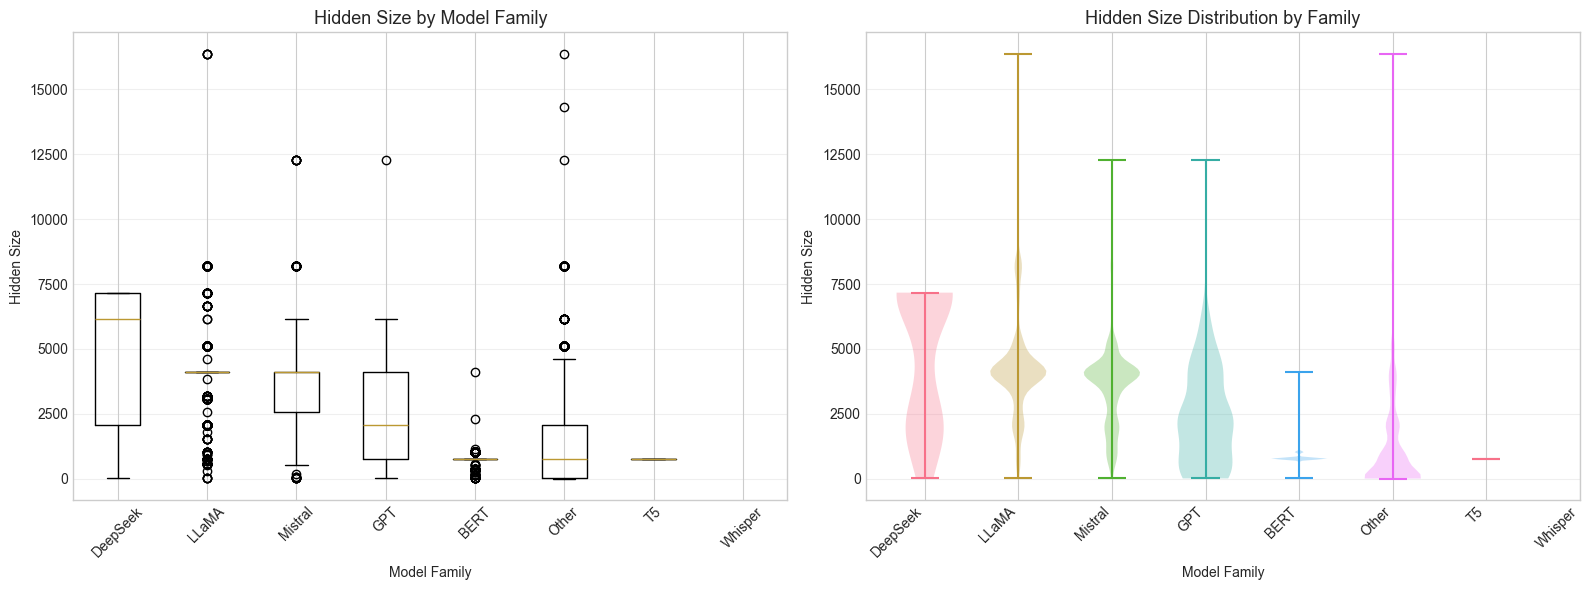

In [20]:
# Filter to families with sufficient samples
family_counts = df['family'].value_counts()
main_families = family_counts[family_counts > 50].index.tolist()
df_main = df[df['family'].isin(main_families)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot - compute order using numeric conversion
hidden_size_numeric = pd.to_numeric(df_main['config_hidden_size'], errors='coerce')
order = df_main.groupby('family').apply(lambda x: hidden_size_numeric[x.index].median()).sort_values(ascending=False).index

# Create box plot manually
positions = range(len(order))
data_by_family = [df_main[df_main['family'] == fam]['config_hidden_size'].dropna() for fam in order]
axes[0].boxplot(data_by_family, positions=positions, labels=order)
axes[0].set_xlabel('Model Family')
axes[0].set_ylabel('Hidden Size')
axes[0].set_title('Hidden Size by Model Family', fontsize=13)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Violin-like distribution plot
for i, fam in enumerate(order):
    fam_data = df_main[df_main['family'] == fam]['config_hidden_size'].dropna()
    if len(fam_data) > 0:
        axes[1].violinplot([fam_data], positions=[i], widths=0.6)
axes[1].set_xticks(positions)
axes[1].set_xticklabels(order, rotation=45, ha='right')
axes[1].set_xlabel('Model Family')
axes[1].set_ylabel('Hidden Size')
axes[1].set_title('Hidden Size Distribution by Family', fontsize=13)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/hidden_size_by_family.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Number of Layers by Family

## 8. Temporal Analysis

**Goal**: Analyze how model families and their architectural parameters have evolved over time.

**Key Questions**:
1. How has family adoption changed over time?
2. How have architectural parameters evolved within each family?
3. When did key features (MoE, GQA) get adopted by different families?

In [ ]:
# Load temporal data
from datetime import datetime

# Try to load from HuggingFace dataset for temporal data
try:
    from datasets import load_dataset
    DATASETS_AVAILABLE = True
except ImportError:
    DATASETS_AVAILABLE = False

if DATASETS_AVAILABLE:
    try:
        dataset = load_dataset("modelbiome/ai_ecosystem", split="train")
        data_dict = {'modelId': dataset['model_id']}
        
        # Map of desired column names to possible dataset column names
        col_mapping = {
            'createdAt': ['createdAt', 'created_at'],
        }
        
        for target_col, possible_cols in col_mapping.items():
            found = False
            for possible_col in possible_cols:
                if possible_col in dataset.column_names:
                    data_dict[target_col] = dataset[possible_col]
                    found = True
                    break
            if not found:
                data_dict[target_col] = [None] * len(dataset)
        
        df_temporal = pd.DataFrame(data_dict)
        print(f"Loaded {len(df_temporal):,} models with temporal data")
    except Exception as e:
        print(f"Error loading from HuggingFace: {e}")
        df_temporal = pd.DataFrame({'modelId': df['modelId'], 'createdAt': None})
        print("Created minimal dataframe - temporal analysis will be limited")
else:
    # Try local CSV files
    import os
    alt_paths = [
        '../data/ai_ecosystem_expanded.csv',
        '../data/ai_ecosystem.csv',
    ]
    found = False
    for path in alt_paths:
        if os.path.exists(path):
            df_temporal = pd.read_csv(path, low_memory=False)
            if 'modelId' not in df_temporal.columns and 'model_id' in df_temporal.columns:
                df_temporal['modelId'] = df_temporal['model_id']
            if 'createdAt' not in df_temporal.columns:
                df_temporal['createdAt'] = None
            print(f"Loaded {len(df_temporal):,} models from {path}")
            found = True
            break
    
    if not found:
        df_temporal = pd.DataFrame({'modelId': df['modelId'], 'createdAt': None})
        print("Created minimal dataframe - temporal analysis will be limited")

# Merge temporal data with main dataframe
# Check if df_main exists, if not create it from df
if 'df_main' not in locals():
    # Create df_main if it doesn't exist (filter to main families)
    family_counts = df['family'].value_counts()
    main_families = family_counts[family_counts > 50].index.tolist()
    df_main = df[df['family'].isin(main_families)].copy()

# Merge temporal data
if 'createdAt' in df_main.columns:
    # If createdAt already exists, update it with new data if available
    df_main = df_main.merge(df_temporal[['modelId', 'createdAt']], on='modelId', how='left', suffixes=('', '_new'))
    if 'createdAt_new' in df_main.columns:
        df_main['createdAt'] = df_main['createdAt_new'].fillna(df_main['createdAt'])
        df_main = df_main.drop(columns=['createdAt_new'])
else:
    # If createdAt doesn't exist, just merge it in
    df_main = df_main.merge(df_temporal[['modelId', 'createdAt']], on='modelId', how='left')

# Parse dates
def parse_date(date_str):
    if pd.isna(date_str) or date_str is None:
        return None
    if isinstance(date_str, str):
        try:
            return pd.to_datetime(date_str)
        except:
            return None
    return date_str

df_main['created_date'] = df_main['createdAt'].apply(parse_date)

# Only proceed if we have valid dates
if df_main['created_date'].notna().sum() > 0:
    df_main['year_month'] = df_main['created_date'].dt.to_period('M')
    df_dated = df_main[df_main['created_date'].notna()].copy()
    print(f"\nModels with valid dates: {len(df_dated):,}")
    print(f"Date range: {df_dated['created_date'].min()} to {df_dated['created_date'].max()}")
else:
    df_dated = pd.DataFrame()
    print("\nNo valid dates available - temporal analysis will be skipped")

In [ ]:
# 8.1 Family Adoption Over Time
if len(df_dated) > 0:
    # Count models by family and month
    family_monthly = df_dated.groupby(['year_month', 'family']).size().unstack(fill_value=0)
    
    # Calculate cumulative counts
    family_cumulative = family_monthly.cumsum()
    
    # Plot cumulative adoption
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Top: Cumulative adoption
    for family in main_families:
        if family in family_cumulative.columns:
            axes[0].plot(family_cumulative.index.astype(str), family_cumulative[family], 
                        label=family, linewidth=2, marker='o', markersize=3)
    
    axes[0].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[0].set_ylabel('Cumulative Model Count', fontsize=11)
    axes[0].set_title('Cumulative Model Family Adoption Over Time', fontsize=13)
    axes[0].legend(loc='upper left', fontsize=9)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Bottom: Monthly new models
    for family in main_families:
        if family in family_monthly.columns:
            axes[1].plot(family_monthly.index.astype(str), family_monthly[family], 
                        label=family, linewidth=2, marker='o', markersize=3, alpha=0.7)
    
    axes[1].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[1].set_ylabel('New Models per Month', fontsize=11)
    axes[1].set_title('Monthly New Models by Family', fontsize=13)
    axes[1].legend(loc='upper left', fontsize=9)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('figures/family_adoption_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\nFamily adoption summary:")
    for family in main_families:
        if family in family_cumulative.columns:
            total = family_cumulative[family].iloc[-1] if len(family_cumulative) > 0 else 0
            first_month = family_cumulative[family_cumulative[family] > 0].index[0] if (family_cumulative[family] > 0).any() else None
            print(f"  {family}: {total:,} models (first: {first_month})")
else:
    print("Skipping temporal analysis - no date data available")

In [ ]:
# 8.2 Parameter Trends Over Time by Family
if len(df_dated) > 0:
    # Focus on key families with enough data
    key_families = ['LLaMA', 'Mistral', 'GPT', 'BERT', 'DeepSeek']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Hidden Size over time
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:  # Need enough data points
            hidden_numeric = pd.to_numeric(fam_data['config_hidden_size'], errors='coerce')
            fam_data['hidden_size'] = hidden_numeric
            monthly_median = fam_data.groupby('year_month')['hidden_size'].median()
            if len(monthly_median) > 0:
                axes[0,0].plot(monthly_median.index.astype(str), monthly_median.values, 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[0,0].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[0,0].set_ylabel('Median Hidden Size', fontsize=11)
    axes[0,0].set_title('Hidden Size Evolution by Family', fontsize=13)
    axes[0,0].legend(fontsize=9)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Number of Layers over time
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            layers_numeric = pd.to_numeric(fam_data['config_num_hidden_layers'], errors='coerce')
            fam_data['num_layers'] = layers_numeric
            monthly_median = fam_data.groupby('year_month')['num_layers'].median()
            if len(monthly_median) > 0:
                axes[0,1].plot(monthly_median.index.astype(str), monthly_median.values, 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[0,1].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[0,1].set_ylabel('Median Number of Layers', fontsize=11)
    axes[0,1].set_title('Number of Layers Evolution by Family', fontsize=13)
    axes[0,1].legend(fontsize=9)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Context Length over time (log scale)
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            ctx_numeric = pd.to_numeric(fam_data['config_max_position_embeddings'], errors='coerce')
            fam_data['context'] = ctx_numeric
            monthly_median = fam_data.groupby('year_month')['context'].median()
            if len(monthly_median) > 0:
                axes[1,0].plot(monthly_median.index.astype(str), monthly_median.values, 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[1,0].set_yscale('log')
    axes[1,0].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[1,0].set_ylabel('Median Context Length (log scale)', fontsize=11)
    axes[1,0].set_title('Context Length Evolution by Family', fontsize=13)
    axes[1,0].legend(fontsize=9)
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Approximate Parameters over time
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            params_numeric = pd.to_numeric(fam_data['config_approx_params_billions'], errors='coerce')
            fam_data['params'] = params_numeric
            monthly_median = fam_data.groupby('year_month')['params'].median()
            if len(monthly_median) > 0:
                axes[1,1].plot(monthly_median.index.astype(str), monthly_median.values, 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[1,1].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[1,1].set_ylabel('Median Approx Params (Billions)', fontsize=11)
    axes[1,1].set_title('Model Size Evolution by Family', fontsize=13)
    axes[1,1].legend(fontsize=9)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('figures/parameter_trends_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping parameter trends - no date data available")

In [ ]:
# 8.3 Feature Adoption Over Time by Family
if len(df_dated) > 0:
    key_families = ['LLaMA', 'Mistral', 'GPT', 'BERT', 'DeepSeek']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # MoE adoption over time
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            monthly_stats = fam_data.groupby('year_month').agg({
                'uses_moe': lambda x: (x == True).sum(),
                'modelId': 'count'
            })
            monthly_stats.columns = ['moe_count', 'total']
            monthly_stats['moe_rate'] = (monthly_stats['moe_count'] / monthly_stats['total'] * 100).fillna(0)
            if len(monthly_stats) > 0:
                axes[0,0].plot(monthly_stats.index.astype(str), monthly_stats['moe_rate'], 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[0,0].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[0,0].set_ylabel('MoE Adoption Rate (%)', fontsize=11)
    axes[0,0].set_title('MoE Adoption Over Time by Family', fontsize=13)
    axes[0,0].legend(fontsize=9)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].set_ylim([0, 105])
    
    # GQA adoption over time
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            monthly_stats = fam_data.groupby('year_month').agg({
                'uses_gqa': lambda x: (x == True).sum(),
                'modelId': 'count'
            })
            monthly_stats.columns = ['gqa_count', 'total']
            monthly_stats['gqa_rate'] = (monthly_stats['gqa_count'] / monthly_stats['total'] * 100).fillna(0)
            if len(monthly_stats) > 0:
                axes[0,1].plot(monthly_stats.index.astype(str), monthly_stats['gqa_rate'], 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[0,1].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[0,1].set_ylabel('GQA Adoption Rate (%)', fontsize=11)
    axes[0,1].set_title('GQA Adoption Over Time by Family', fontsize=13)
    axes[0,1].legend(fontsize=9)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].set_ylim([0, 105])
    
    # RoPE adoption over time
    for family in key_families:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            monthly_stats = fam_data.groupby('year_month').agg({
                'uses_rope': lambda x: (x == True).sum(),
                'modelId': 'count'
            })
            monthly_stats.columns = ['rope_count', 'total']
            monthly_stats['rope_rate'] = (monthly_stats['rope_count'] / monthly_stats['total'] * 100).fillna(0)
            if len(monthly_stats) > 0:
                axes[1,0].plot(monthly_stats.index.astype(str), monthly_stats['rope_rate'], 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[1,0].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[1,0].set_ylabel('RoPE Adoption Rate (%)', fontsize=11)
    axes[1,0].set_title('RoPE Adoption Over Time by Family', fontsize=13)
    axes[1,0].legend(fontsize=9)
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].set_ylim([0, 105])
    
    # Context length categories over time (for LLaMA and Mistral)
    for family in ['LLaMA', 'Mistral', 'DeepSeek']:
        fam_data = df_dated[df_dated['family'] == family].copy()
        if len(fam_data) > 10:
            ctx_numeric = pd.to_numeric(fam_data['config_max_position_embeddings'], errors='coerce')
            fam_data['context'] = ctx_numeric
            # Categorize context lengths
            fam_data['ctx_category'] = pd.cut(
                fam_data['context'],
                bins=[0, 4096, 32768, 131072, float('inf')],
                labels=['≤4k', '4k-32k', '32k-128k', '>128k']
            )
            monthly_long = fam_data.groupby('year_month').apply(
                lambda x: (x['ctx_category'].isin(['32k-128k', '>128k'])).sum() / len(x) * 100
            )
            if len(monthly_long) > 0:
                axes[1,1].plot(monthly_long.index.astype(str), monthly_long.values, 
                             label=family, linewidth=2, marker='o', markersize=4)
    
    axes[1,1].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[1,1].set_ylabel('Long Context Adoption Rate (%)', fontsize=11)
    axes[1,1].set_title('Long Context (≥32k) Adoption Over Time', fontsize=13)
    axes[1,1].legend(fontsize=9)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_ylim([0, 105])
    
    plt.tight_layout()
    plt.savefig('figures/feature_adoption_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Skipping feature adoption trends - no date data available")

In [ ]:
# 8.4 Monthly Model Counts by Family (Heatmap)
if len(df_dated) > 0:
    # Create monthly counts by family
    family_monthly_counts = df_dated.groupby(['year_month', 'family']).size().unstack(fill_value=0)
    
    # Select top families by total count
    family_totals = family_monthly_counts.sum().sort_values(ascending=False)
    top_families = family_totals.head(8).index.tolist()
    family_monthly_counts = family_monthly_counts[top_families]
    
    # Normalize by row (month) to show relative proportions
    family_monthly_pct = family_monthly_counts.div(family_monthly_counts.sum(axis=1), axis=0) * 100
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Top: Absolute counts
    im1 = axes[0].imshow(family_monthly_counts.T.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    axes[0].set_yticks(range(len(top_families)))
    axes[0].set_yticklabels(top_families)
    axes[0].set_xticks(range(0, len(family_monthly_counts), max(1, len(family_monthly_counts)//10)))
    axes[0].set_xticklabels([str(x) for x in family_monthly_counts.index[::max(1, len(family_monthly_counts)//10)]], rotation=45)
    axes[0].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[0].set_ylabel('Model Family', fontsize=11)
    axes[0].set_title('Monthly Model Counts by Family (Absolute)', fontsize=13)
    plt.colorbar(im1, ax=axes[0], label='Count')
    
    # Bottom: Percentage of monthly total
    im2 = axes[1].imshow(family_monthly_pct.T.values, aspect='auto', cmap='viridis', interpolation='nearest', vmin=0, vmax=100)
    axes[1].set_yticks(range(len(top_families)))
    axes[1].set_yticklabels(top_families)
    axes[1].set_xticks(range(0, len(family_monthly_pct), max(1, len(family_monthly_pct)//10)))
    axes[1].set_xticklabels([str(x) for x in family_monthly_pct.index[::max(1, len(family_monthly_pct)//10)]], rotation=45)
    axes[1].set_xlabel('Date (Year-Month)', fontsize=11)
    axes[1].set_ylabel('Model Family', fontsize=11)
    axes[1].set_title('Monthly Model Distribution by Family (% of Monthly Total)', fontsize=13)
    plt.colorbar(im2, ax=axes[1], label='Percentage')
    
    plt.tight_layout()
    plt.savefig('figures/family_monthly_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nMonthly model counts summary (top {len(top_families)} families):")
    print(family_monthly_counts.sum().sort_values(ascending=False))
else:
    print("Skipping monthly heatmap - no date data available")

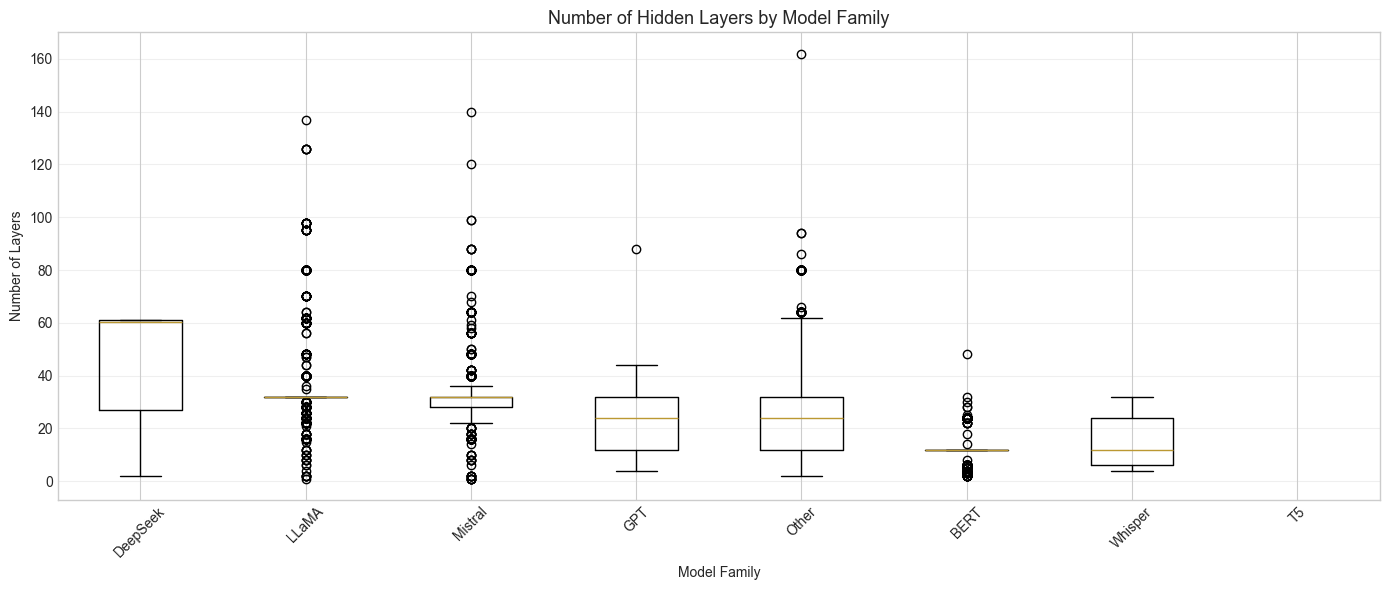


Layer statistics by family:
          mean  median  min    max   count
family                                    
DeepSeek  43.6    60.5  2.0   61.0    51.0
LLaMA     36.4    32.0  1.0  137.0  1287.0
Mistral   32.8    32.0  1.0  140.0  1486.0
GPT       23.6    24.0  4.0   88.0  2938.0
Other     24.9    24.0  2.0  162.0  6132.0
BERT      13.1    12.0  2.0   48.0  2021.0
Whisper   14.9    12.0  4.0   32.0   214.0
T5         NaN     NaN  NaN    NaN   428.0


In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

# Convert to numeric and compute order
layers_numeric = pd.to_numeric(df_main['config_num_hidden_layers'], errors='coerce')
order = df_main.groupby('family').apply(lambda x: layers_numeric[x.index].median()).sort_values(ascending=False).index

# Create box plot
positions = range(len(order))
data_by_family = [df_main[df_main['family'] == fam]['config_num_hidden_layers'].dropna() for fam in order]
ax.boxplot(data_by_family, positions=positions, labels=order)
ax.set_xlabel('Model Family')
ax.set_ylabel('Number of Layers')
ax.set_title('Number of Hidden Layers by Model Family', fontsize=13)
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/layers_by_family.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics by family
print("\nLayer statistics by family:")
layer_stats = df_main.groupby('family').apply(
    lambda x: pd.Series({
        'mean': layers_numeric[x.index].mean(),
        'median': layers_numeric[x.index].median(),
        'min': layers_numeric[x.index].min(),
        'max': layers_numeric[x.index].max(),
        'count': len(x)
    })
).round(1)
print(layer_stats.sort_values('median', ascending=False))

## 4. Feature Adoption by Family

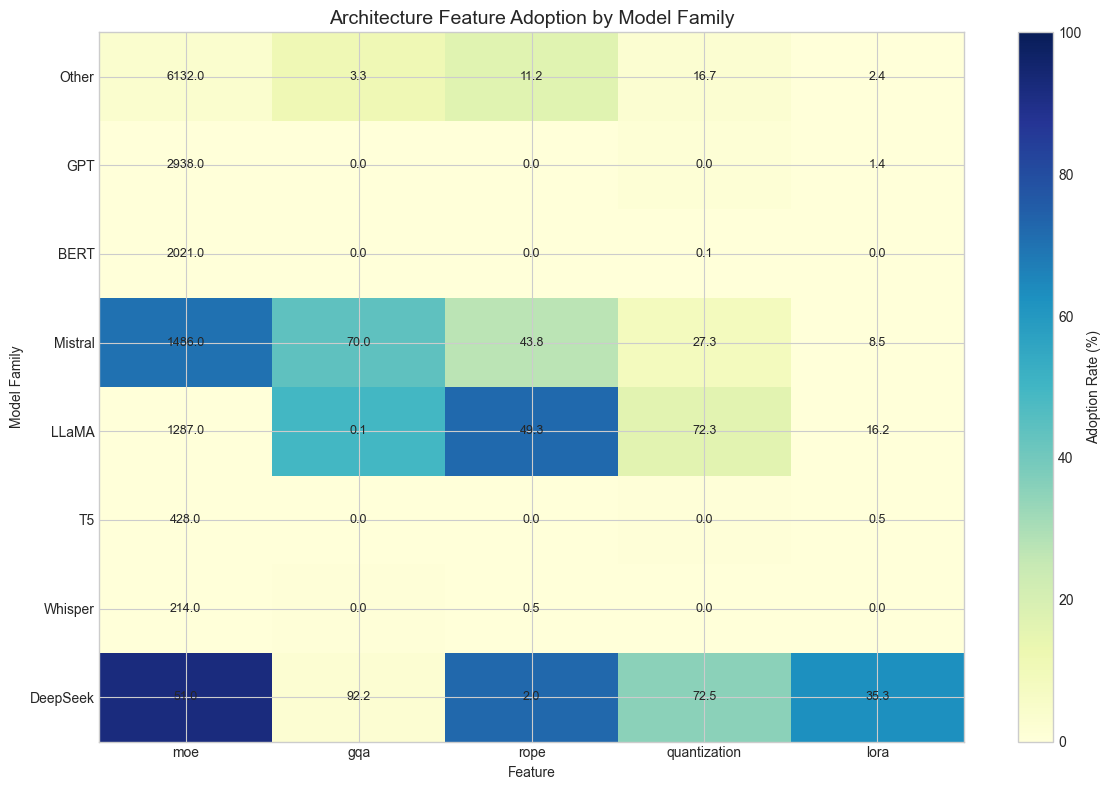

In [22]:
# Calculate feature adoption rates by family
features = ['uses_moe', 'uses_gqa', 'uses_rope', 'uses_quantization', 'uses_lora']

adoption_rates = []
for family in main_families:
    family_df = df_main[df_main['family'] == family]
    rates = {'family': family, 'count': len(family_df)}
    for feat in features:
        if feat in family_df.columns:
            rate = (family_df[feat] == True).sum() / len(family_df) * 100
            rates[feat.replace('uses_', '')] = rate
    adoption_rates.append(rates)

rates_df = pd.DataFrame(adoption_rates).set_index('family')
feature_cols = [f.replace('uses_', '') for f in features if f.replace('uses_', '') in rates_df.columns]

# Ensure all feature columns exist and fill missing with 0
for col in feature_cols:
    if col not in rates_df.columns:
        rates_df[col] = 0

# Reorder columns to match feature_cols
rates_df = rates_df[feature_cols]

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: Heatmap with better colormap (RdYlGn - red for low, green for high)
im = axes[0].imshow(rates_df.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
axes[0].set_xticks(range(len(feature_cols)))
axes[0].set_xticklabels(feature_cols, rotation=45, ha='right')
axes[0].set_yticks(range(len(rates_df)))
axes[0].set_yticklabels(rates_df.index)
for i in range(len(rates_df)):
    for j in range(len(feature_cols)):
        value = rates_df.iloc[i, j]
        # Use white text for dark colors, black for light colors
        text_color = 'white' if value < 50 else 'black'
        axes[0].text(j, i, f'{value:.1f}%', ha='center', va='center', 
                     fontsize=10, fontweight='bold', color=text_color)
plt.colorbar(im, ax=axes[0], label='Adoption Rate (%)')
axes[0].set_title('Feature Adoption Heatmap', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Model Family', fontsize=12)
axes[0].set_xlabel('Feature', fontsize=12)

# Right: Stacked bar chart showing adoption rates
x_pos = np.arange(len(rates_df))
width = 0.6
bottom = np.zeros(len(rates_df))

# Color palette for features
colors = plt.cm.Set3(np.linspace(0, 1, len(feature_cols)))

for idx, feat in enumerate(feature_cols):
    values = rates_df[feat].values
    axes[1].bar(x_pos, values, width, bottom=bottom, label=feat, color=colors[idx], alpha=0.8)
    bottom += values

axes[1].set_xlabel('Model Family', fontsize=12)
axes[1].set_ylabel('Adoption Rate (%)', fontsize=12)
axes[1].set_title('Feature Adoption Stacked Bar Chart', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(rates_df.index, rotation=45, ha='right')
axes[1].legend(loc='upper left', fontsize=9)
axes[1].set_ylim([0, 100])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/feature_adoption_by_family.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature adoption rates by family:")
print(rates_df.round(1))

## 5. Context Length by Family

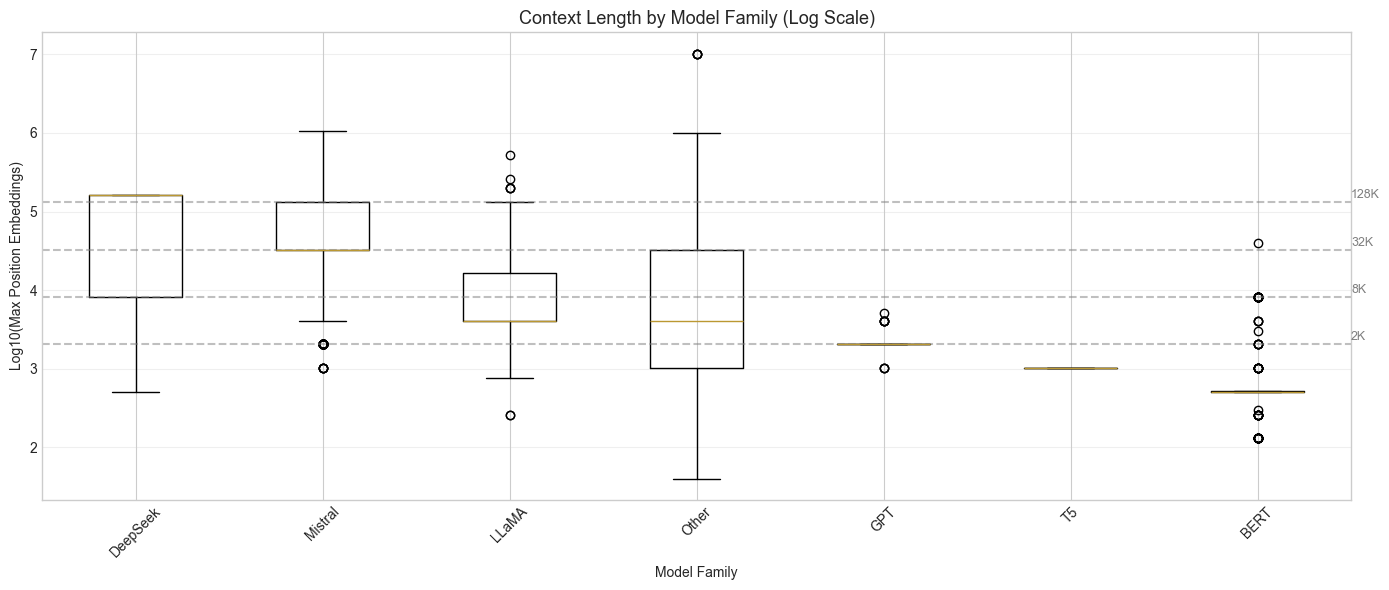

In [23]:
fig, ax = plt.subplots(figsize=(14, 6))

# Use log scale for context length
df_ctx = df_main[df_main['config_max_position_embeddings'].notna()].copy()
ctx_numeric = pd.to_numeric(df_ctx['config_max_position_embeddings'], errors='coerce')
df_ctx['log_context'] = np.log10(ctx_numeric)

order = df_ctx.groupby('family').apply(lambda x: df_ctx.loc[x.index, 'log_context'].median()).sort_values(ascending=False).index

positions = range(len(order))
data_by_family = [df_ctx[df_ctx['family'] == fam]['log_context'].dropna() for fam in order]
ax.boxplot(data_by_family, positions=positions, labels=order)
ax.set_xlabel('Model Family')
ax.set_ylabel('Log10(Max Position Embeddings)')
ax.set_title('Context Length by Model Family (Log Scale)', fontsize=13)

# Add reference lines
for ctx, label in [(np.log10(2048), '2K'), (np.log10(8192), '8K'), 
                    (np.log10(32768), '32K'), (np.log10(131072), '128K')]:
    ax.axhline(ctx, color='gray', linestyle='--', alpha=0.5)
    ax.text(len(order)-0.5, ctx+0.05, label, fontsize=9, color='gray')

ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('figures/context_by_family.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. GQA Ratio by Family

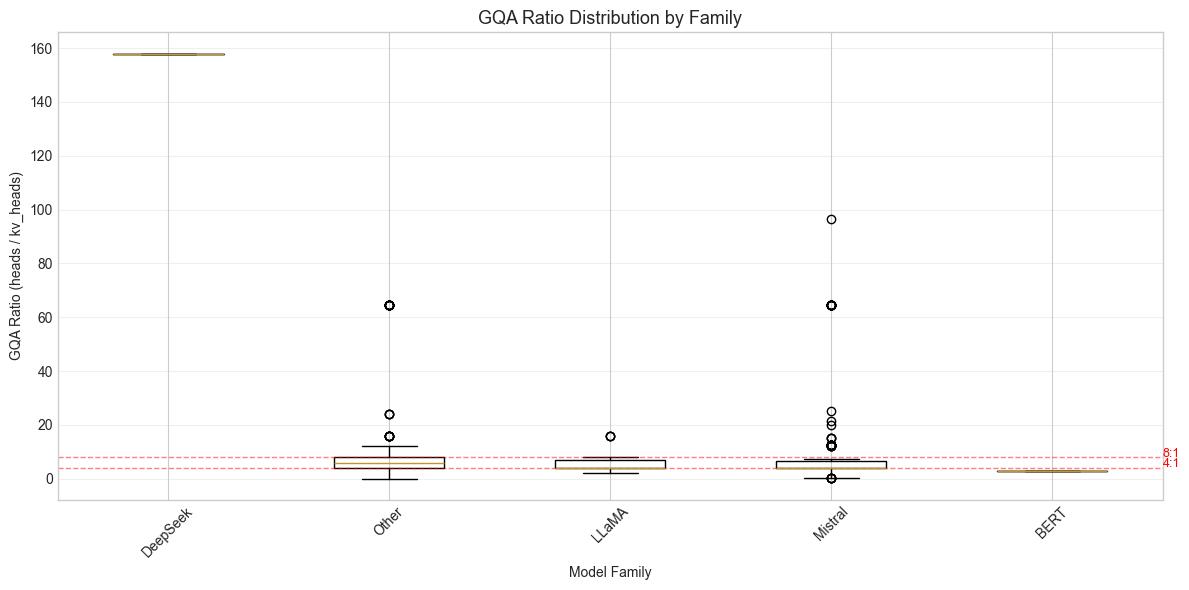


GQA Ratio by family:
            mean  median  count
family                         
BERT        3.00    3.00    1.0
DeepSeek  157.96  157.96    1.0
LLaMA       4.95    4.00  630.0
Mistral     6.86    4.00  651.0
Other       7.17    6.00  677.0


In [24]:
# Filter to models with GQA
df_gqa = df_main[(df_main['uses_gqa'] == True) & (df_main['config_gqa_ratio'].notna())].copy()
gqa_ratio_numeric = pd.to_numeric(df_gqa['config_gqa_ratio'], errors='coerce')

fig, ax = plt.subplots(figsize=(12, 6))

if len(df_gqa) > 0:
    order = df_gqa.groupby('family').apply(lambda x: gqa_ratio_numeric[x.index].median()).sort_values(ascending=False).index
    
    positions = range(len(order))
    data_by_family = [df_gqa[df_gqa['family'] == fam]['config_gqa_ratio'].dropna() for fam in order]
    
    # Use log scale since DeepSeek has much higher ratios (~158) than others (~3-7)
    ax.boxplot(data_by_family, positions=positions, labels=order)
    ax.set_yscale('log')
    ax.set_xlabel('Model Family')
    ax.set_ylabel('GQA Ratio (heads / kv_heads, log scale)')
    ax.set_title('GQA Ratio Distribution by Family', fontsize=13)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add annotations for common ratios (on log scale)
    for ratio in [4, 8, 16, 32, 64, 128]:
        ax.axhline(ratio, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax.text(len(order)-0.5, ratio*1.1, f'{ratio}:1', fontsize=9, color='red')

plt.tight_layout()
plt.savefig('figures/gqa_ratio_by_family.png', dpi=300, bbox_inches='tight')
plt.show()

if len(df_gqa) > 0:
    print("\nGQA Ratio by family:")
    gqa_stats = df_gqa.groupby('family').apply(
        lambda x: pd.Series({
            'mean': gqa_ratio_numeric[x.index].mean(),
            'median': gqa_ratio_numeric[x.index].median(),
            'count': len(x)
        })
    ).round(2)
    print(gqa_stats)

## 7. Multi-Panel Family Comparison

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = [
    ('config_hidden_size', 'Hidden Size', 'steelblue'),
    ('config_num_hidden_layers', 'Num Layers', 'teal'),
    ('config_vocab_size', 'Vocab Size', 'purple'),
    ('config_max_position_embeddings', 'Context Length', 'darkorange'),
    ('config_num_attention_heads', 'Attention Heads', 'crimson'),
    ('config_approx_params_billions', 'Approx Params (B)', 'forestgreen')
]

for ax, (col, title, color) in zip(axes.flatten(), metrics):
    df_plot = df_main[df_main[col].notna()].copy()
    col_numeric = pd.to_numeric(df_plot[col], errors='coerce')
    
    if len(df_plot) > 0:
        order = df_plot.groupby('family').apply(lambda x: col_numeric[x.index].median()).sort_values(ascending=False).index
        
        positions = range(len(order))
        data_by_family = [df_plot[df_plot['family'] == fam][col].dropna() for fam in order]
        ax.boxplot(data_by_family, positions=positions, labels=order)
        
        # Use log scale for attention heads and context length
        if col == 'config_num_attention_heads':
            ax.set_yscale('log')
            ax.set_ylabel(f'{title} (log scale)')
        elif col == 'config_max_position_embeddings':
            ax.set_yscale('log')
            ax.set_ylabel(f'{title} (log scale)')
        else:
            ax.set_ylabel(title)
        
        ax.set_xlabel('')
        ax.set_title(f'{title} by Family', fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Parameters by Family', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('figures/family_comparison_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. DeepSeek vs Mistral Deep Dive

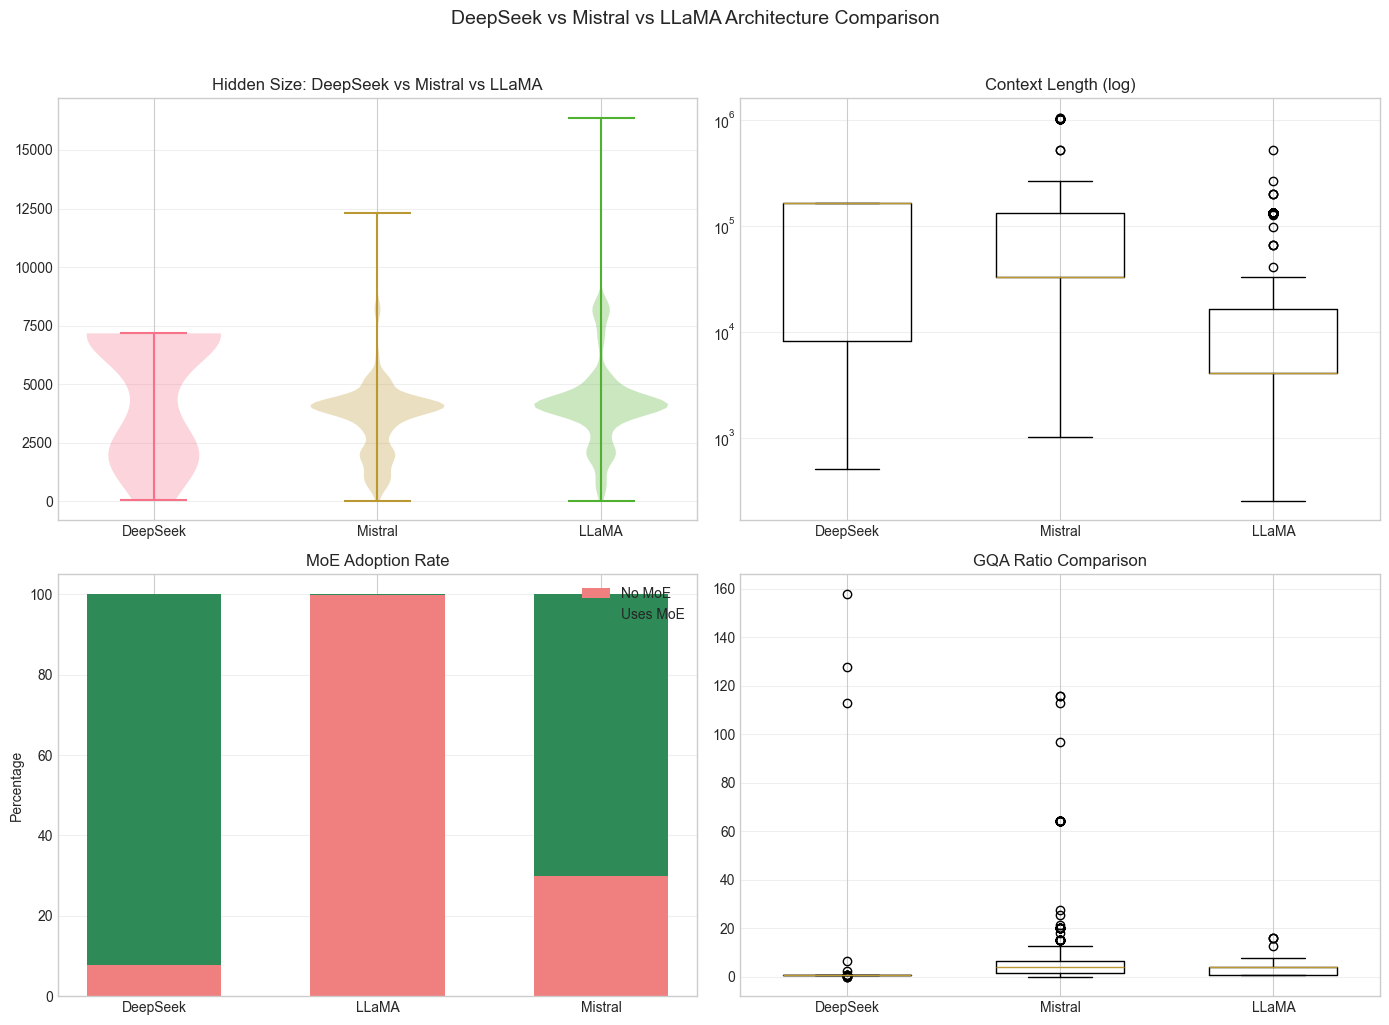

In [ ]:
# Focus on DeepSeek and Mistral families
df_ds = df_main[df_main['family'].isin(['DeepSeek', 'Mistral', 'LLaMA'])].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hidden Size comparison
hidden_ds = pd.to_numeric(df_ds['config_hidden_size'], errors='coerce')
for i, family in enumerate(['DeepSeek', 'Mistral', 'LLaMA']):
    fam_data = df_ds[df_ds['family'] == family]['config_hidden_size'].dropna()
    if len(fam_data) > 0:
        axes[0,0].violinplot([fam_data], positions=[i], widths=0.6)
axes[0,0].set_xticks(range(3))
axes[0,0].set_xticklabels(['DeepSeek', 'Mistral', 'LLaMA'])
axes[0,0].set_title('Hidden Size: DeepSeek vs Mistral vs LLaMA', )
axes[0,0].grid(True, alpha=0.3, axis='y')

# Context Length comparison
df_ds_ctx = df_ds[df_ds['config_max_position_embeddings'].notna()].copy()
ctx_ds = pd.to_numeric(df_ds_ctx['config_max_position_embeddings'], errors='coerce')
for i, family in enumerate(['DeepSeek', 'Mistral', 'LLaMA']):
    fam_data = df_ds_ctx[df_ds_ctx['family'] == family]['config_max_position_embeddings'].dropna()
    if len(fam_data) > 0:
        axes[0,1].boxplot([fam_data], positions=[i], widths=0.6)
axes[0,1].set_xticks(range(3))
axes[0,1].set_xticklabels(['DeepSeek', 'Mistral', 'LLaMA'])
axes[0,1].set_yscale('log')
axes[0,1].set_title('Context Length (log)', )
axes[0,1].grid(True, alpha=0.3, axis='y')

# MoE adoption (stacked bar)
moe_data = df_ds.groupby('family')['uses_moe'].value_counts(normalize=True).unstack().fillna(0) * 100
if len(moe_data) > 0:
    x_pos = np.arange(len(moe_data.index))
    width = 0.6
    if False in moe_data.columns:
        axes[1,0].bar(x_pos, moe_data[False], width, label='No MoE', color='lightcoral')
    if True in moe_data.columns:
        bottom = moe_data[False] if False in moe_data.columns else 0
        axes[1,0].bar(x_pos, moe_data[True], width, bottom=bottom, label='Uses MoE', color='seagreen')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(moe_data.index)
    axes[1,0].set_ylabel('Percentage')
    axes[1,0].set_title('MoE Adoption Rate', )
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3, axis='y')

# GQA Ratio comparison
df_ds_gqa = df_ds[df_ds['config_gqa_ratio'].notna()].copy()
gqa_ds = pd.to_numeric(df_ds_gqa['config_gqa_ratio'], errors='coerce')
if len(df_ds_gqa) > 0:
    for i, family in enumerate(['DeepSeek', 'Mistral', 'LLaMA']):
        fam_data = df_ds_gqa[df_ds_gqa['family'] == family]['config_gqa_ratio'].dropna()
        if len(fam_data) > 0:
            axes[1,1].boxplot([fam_data], positions=[i], widths=0.6)
    axes[1,1].set_xticks(range(3))
    axes[1,1].set_xticklabels(['DeepSeek', 'Mistral', 'LLaMA'])
    axes[1,1].set_title('GQA Ratio Comparison', )
    axes[1,1].grid(True, alpha=0.3, axis='y')

plt.suptitle('DeepSeek vs Mistral vs LLaMA Architecture Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('figures/deepseek_mistral_llama_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Summary Statistics Table

In [ ]:
# Generate comprehensive summary by family
summary = []
for family in main_families:
    fam_df = df_main[df_main['family'] == family]
    
    hidden_numeric = pd.to_numeric(fam_df['config_hidden_size'], errors='coerce')
    layers_numeric = pd.to_numeric(fam_df['config_num_hidden_layers'], errors='coerce')
    ctx_numeric = pd.to_numeric(fam_df['config_max_position_embeddings'], errors='coerce')
    
    row = {
        'Family': family,
        'Count': len(fam_df),
        'Median Hidden': hidden_numeric.median(),
        'Median Layers': layers_numeric.median(),
        'Median Context': ctx_numeric.median(),
        'MoE %': (fam_df['uses_moe'] == True).mean() * 100,
        'GQA %': (fam_df['uses_gqa'] == True).mean() * 100,
        'RoPE %': (fam_df['uses_rope'] == True).mean() * 100,
    }
    summary.append(row)

summary_df = pd.DataFrame(summary).sort_values('Count', ascending=False)
summary_df = summary_df.round(1)

print("\n" + "="*80)
print("MODEL FAMILY SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

summary_df.to_csv('family_summary.csv', index=False)
print("\n✓ Summary saved to family_summary.csv")


MODEL FAMILY SUMMARY
  Family  Count  Median Hidden  Median Layers  Median Context  MoE %  GQA %  RoPE %
   Other   6132          768.0           24.0          4096.0    3.3   11.2    16.7
     GPT   2938         2048.0           24.0          2048.0    0.0    0.0     0.0
    BERT   2021          768.0           12.0           512.0    0.0    0.0     0.1
 Mistral   1486         4096.0           32.0         32768.0   70.0   43.8    27.3
   LLaMA   1287         4096.0           32.0          4096.0    0.1   49.3    72.3
      T5    428          768.0            NaN          1024.0    0.0    0.0     0.0
 Whisper    214            NaN           12.0             NaN    0.0    0.5     0.0
DeepSeek     51         6144.0           60.5        163840.0   92.2    2.0    72.5

✓ Summary saved to family_summary.csv
